# Homework 2 : Data from the Web

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import requests
import re
from bs4 import BeautifulSoup

# 1. Top University Ranking : QS
Next we Are going to load the data from the URL of QS. The main URL of the ranking page is the following : 

In [2]:
QS_base_URL = "https://www.topuniversities.com"
QS_data_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508016143198"

Nest, we make the HTTP Request and get the JSON file into a list of dictionnaries :

In [3]:
QS_R = requests.get(QS_data_URL)
QS_dict = QS_R.json()['data']
print(len(QS_dict))
print(QS_dict[0])

959
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}


Create an empty dataFrame for the QS Data :

In [4]:
ranking_QS = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])

print(ranking_QS.dtypes)
print(ranking_QS.head())

Name                                 object
Rank                                 object
Country                              object
Region                               object
Number of faculty members (int)      object
Number of faculty members (total)    object
Number of students (int)             object
Number of students (total)           object
dtype: object
Empty DataFrame
Columns: [Name, Rank, Country, Region, Number of faculty members (int), Number of faculty members (total), Number of students (int), Number of students (total)]
Index: []


We created the following functions. 

The first function takes a beautiful soup and extracts a specific class which it converts from string to int. 

The second function takes in input the ranking dataframe and the dictionnary of the i_th university. The aim of this function is to go look for the missing information which are in the page of the university. 

In [5]:
def get_specific_info(soup, class_):
    try: 
        info = str(soup.find('div', class_= class_).string)
        info = int(info.replace(',',''))
    except:
        info = np.nan
    return info

def get_additional_info(university_dict):
    QS_univ_URL = QS_base_URL + university_dict['url'] # this URL contains additional information that we will extract
    QS_univ_r = requests.get(QS_univ_URL)
    QS_univ_s = BeautifulSoup(QS_univ_r.text,'html.parser')
    
    ### getting info on the faculty members : 
    faculty_int_s = QS_univ_s.find('div', class_= 'total faculty')
    faculty_total_s = QS_univ_s.find('div', class_= 'inter faculty')

    faculty_members = {'In total': get_specific_info(faculty_total_s, 'number'),\
                       'International': get_specific_info(faculty_int_s, 'number')}
    
    ### getting info on the students
    student_total_s = QS_univ_s.find('div', class_= 'total student')
    student_int_s = QS_univ_s.find('div', class_= 'int-students-main')
    
    students = {'In total': get_specific_info(student_total_s, 'number') ,\
                'International': get_specific_info(student_int_s, 'number')}

    return faculty_members,students

The following code allows us to get all the information for the `n_univ` first universities, from the list of dicitonnaries `QS_dict`, and from the university website through the previous function `get_additional_info()`. All this information is set in the previous dataframe  As there are some universities that don't have the information for international faculty member, we decide to add a NaN value. 

In [6]:
n_univ = 201;
for i in range(n_univ):
    univ = QS_dict[i]
    ### Go get the missing information on the page of the univerisity
    [faculty_members,students] = get_additional_info(univ)
    
    ### create the new line of the Dataframe ranking_QS
    univ_data = [ univ['title'],univ['rank_display'].replace('=', ''),univ['country'],univ['region'],\
                      faculty_members['International'], faculty_members['In total'],\
                       students['International'], students['In total']]
    ranking_QS.loc[i] = univ_data
    

Now that we have the dataframe `ranking_QS`, we need to clean a little bit the data and convert into numbers the columns that are in strings

Note that we removed the =XXX in the `Rank` column when 2 universities have the same rank in previous cell

In [7]:
# converting the following columns to int : 
conv_2_int = ['Number of faculty members (int)','Number of faculty members (total)',\
              'Number of students (int)','Number of students (total)', 'Rank']

ranking_QS[conv_2_int] = ranking_QS[conv_2_int].apply(pd.to_numeric)

In [8]:
# display the cleaned dataframe
ranking_QS.head()

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total)
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,1679.0,3717.0,11067.0
1,Stanford University,2,United States,North America,4285.0,2042.0,3611.0,15878.0
2,Harvard University,3,United States,North America,4350.0,1311.0,5266.0,22429.0
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,647.0,2255.0
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,6699.0,18770.0


Now we have our clean dataframe and we can compute the asked values : 

## (a)  Ratio between faculty members and students

In [9]:
ranking_QS['Ratio Faculty/Students'] = ranking_QS['Number of faculty members (total)']/ranking_QS['Number of students (total)']
ratio_fac_students = ranking_QS[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)
ratio_fac_students.head(10)

,Ratio Faculty/Students
Name,
California Institute of Technology (Caltech),0.155211
Massachusetts Institute of Technology (MIT),0.151712
University of Oxford,0.150304
Yale University,0.137720
Imperial College London,0.128713
Stanford University,0.128606
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.125689
University of Cambridge,0.121364
"Nanyang Technological University, Singapore (NTU)",0.116287


## (b)  Ratio of international students

In [10]:
ranking_QS['Ratio Int/Total Students'] = ranking_QS['Number of students (int)']/ranking_QS['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)
ratio_int_students.head(10)

,Ratio Int/Total Students
Name,
London School of Economics and Political Science (LSE),0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
Imperial College London,0.543567
Maastricht University,0.502533
Carnegie Mellon University,0.478062
UCL (University College London),0.477928
University of St Andrews,0.457955
The University of Melbourne,0.427434
Queen Mary University of London,0.421816


### (c) By country : average ratio of international students and  ratio between faculty members and students

We are going to display the same statistic but for each country. We only consider the Top 10 countries here.

# TODO : ask if average by country or sorting by country

In [11]:
# Top 10 : ratio of international students by country
country_rank_int_total_students = ranking_QS.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
country_rank_int_total_students.head(10)

#https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups
#ranking_QS.groupby('Country').sort_values('Ratio Int/Total Students',ascending=False)\
#            [['Ratio Int/Total Students']].head(10)

,Ratio Int/Total Students
Country,
United Kingdom,0.350246
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095
Singapore,0.277091
Canada,0.252604
New Zealand,0.248971
Netherlands,0.245456


In [12]:
# Top 10 : ratio between faculty members and students by country
country_rank_fac_students= ranking_QS.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]
    
country_rank_fac_students.head(10)                                              

,Ratio Faculty/Students
Country,
Saudi Arabia,0.110099
Singapore,0.105290
Hong Kong,0.083023
Switzerland,0.082517
Denmark,0.068164
United Kingdom,0.052498
France,0.042596
Australia,0.039336
United States,0.037463


### (d) By region : average ratio of international students and  ratio between faculty members and students

We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

# TODO : ask if average by region or sorting by region

In [13]:
# Ratio of international students by region
region_int_total_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
region_int_total_students.head(10)

,Ratio Int/Total Students
Region,
Oceania,0.329077
Europe,0.246761
North America,0.202437
Africa,0.169703
Asia,0.132394
Latin America,0.071751


In [14]:
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

## 1.2. Bar Plots

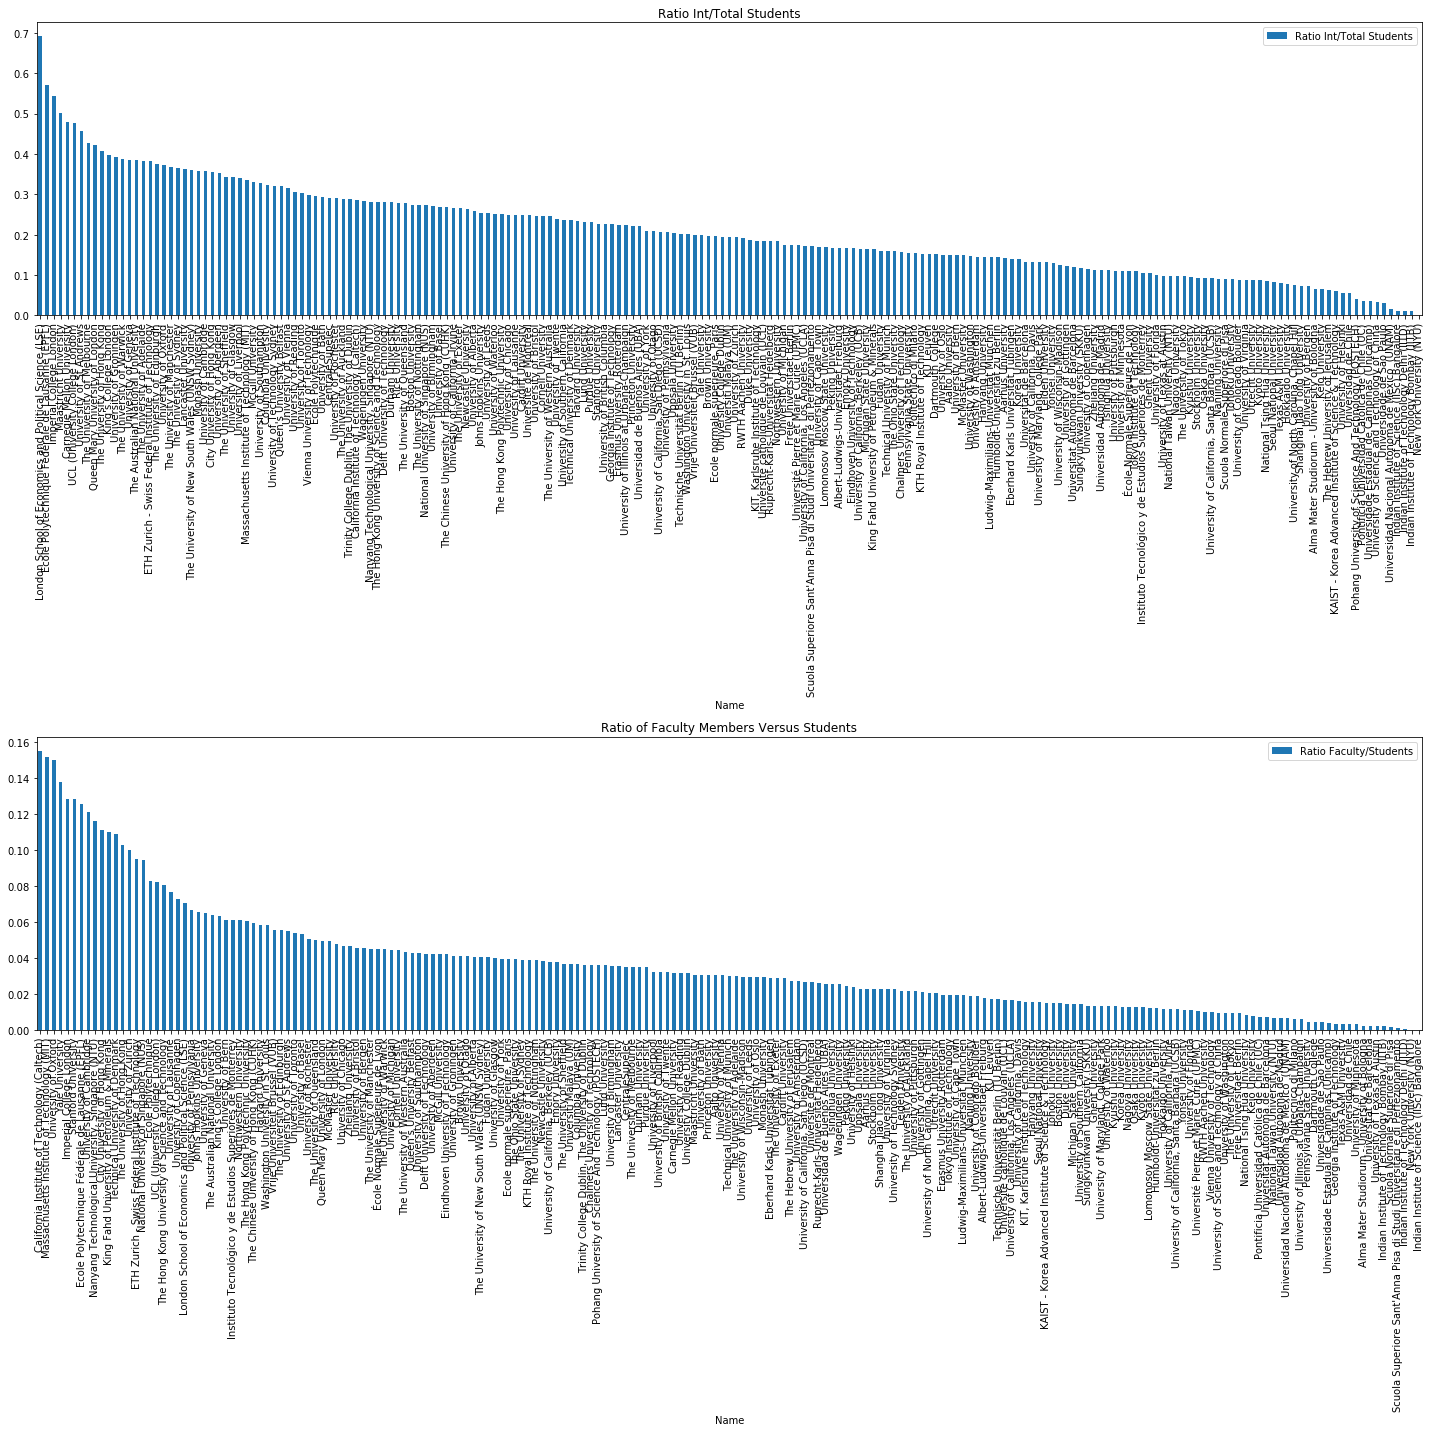

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols =1, figsize  = (20,20))
ratio_int_students.plot(kind = "bar", subplots = True, ax = axes[0])
plt.title("Ratio of International Students")
ratio_fac_students.plot(kind = "bar", subplots = True, ax = axes[1])
plt.title("Ratio of Faculty Members Versus Students")
fig.tight_layout()

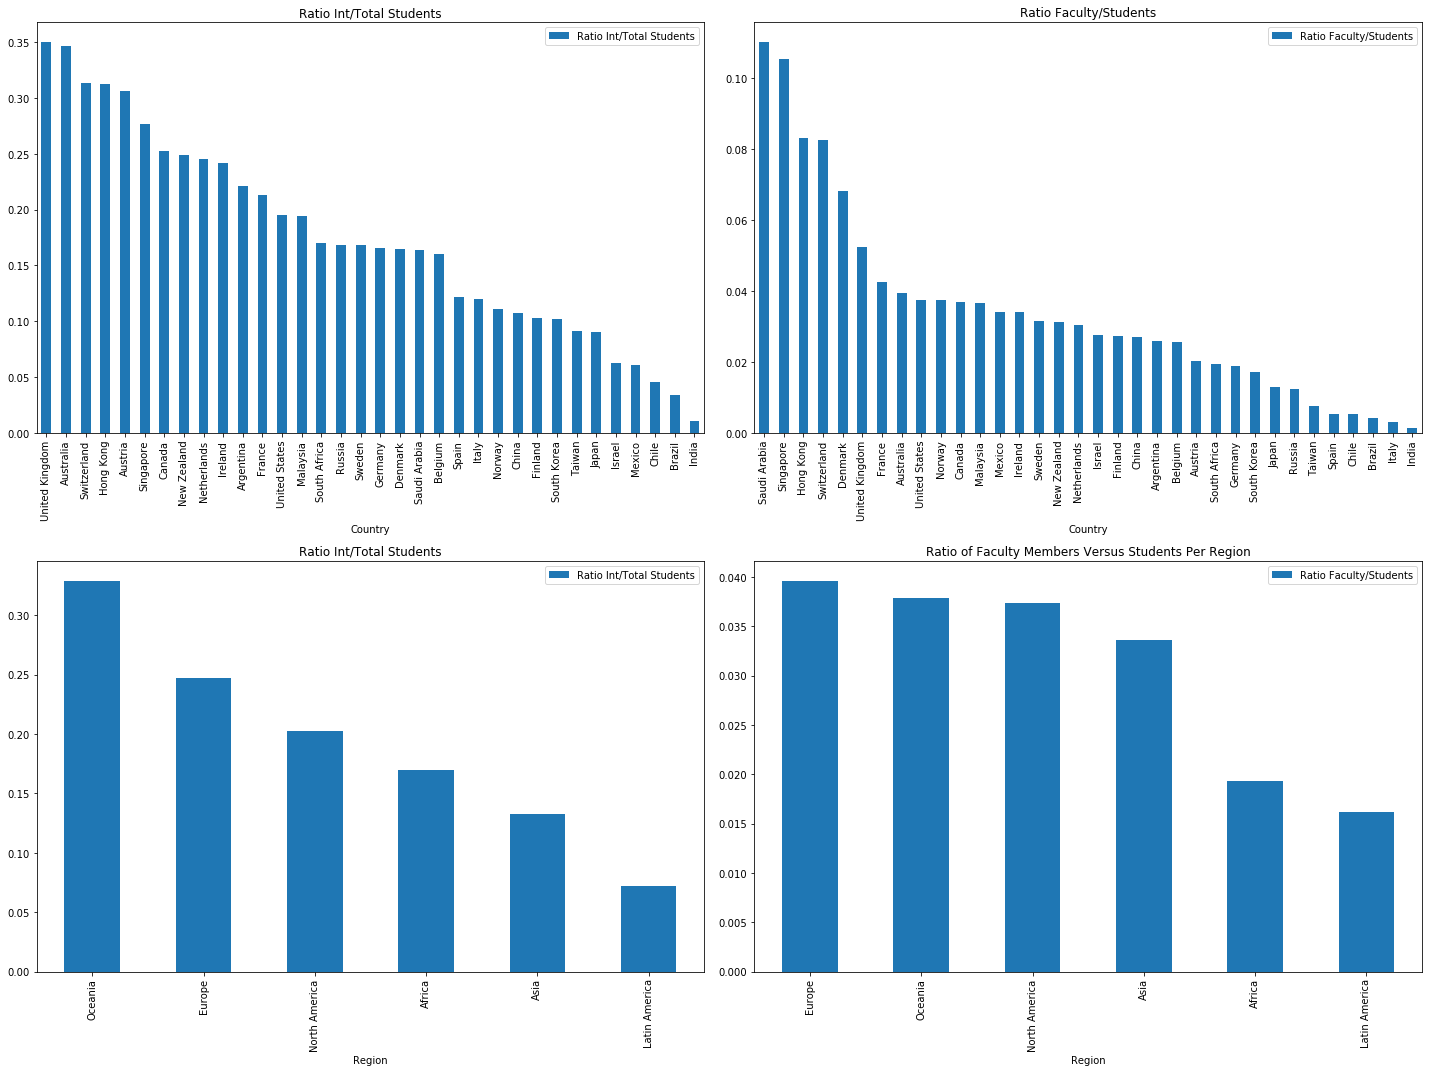

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols =2, figsize  = (20,15))
country_rank_int_total_students.plot(kind = "bar", subplots = True, ax = axes[0,0])
plt.title("Ratio of International Students Per Country")
country_rank_fac_students.plot(kind = "bar", subplots = True, ax = axes[0,1])
plt.title("Ratio of Faculty Members Versus Students Per Country")
region_int_total_students.plot(kind = "bar", subplots = True, ax = axes[1,0])
plt.title("Ratio of International Students Per Region")
region_fac_students.plot(kind = "bar", subplots = True, ax = axes[1,1])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

# 2. Top University Ranking : THE
Next we Are going to load the data from the URL of THE. The main URL of the ranking page is the following : 

## 2.1. Mapping Countries to Regions 

Using the countries and regions columns, we can map each country to a specific region by converting the resulting dataframe to a dictionary

In [17]:
region_mapping = ranking_QS[['Country', 'Region']].set_index('Country').to_dict()['Region']
print(region_mapping)

{'United States': 'North America', 'United Kingdom': 'Europe', 'Switzerland': 'Europe', 'Singapore': 'Asia', 'Australia': 'Oceania', 'China': 'Asia', 'Hong Kong': 'Asia', 'Japan': 'Asia', 'Canada': 'North America', 'South Korea': 'Asia', 'France': 'Europe', 'Netherlands': 'Europe', 'Germany': 'Europe', 'Belgium': 'Europe', 'Denmark': 'Europe', 'Argentina': 'Latin America', 'Taiwan': 'Asia', 'Sweden': 'Europe', 'New Zealand': 'Oceania', 'Ireland': 'Europe', 'Russia': 'Europe', 'Finland': 'Europe', 'Malaysia': 'Asia', 'Brazil': 'Latin America', 'Mexico': 'Latin America', 'Chile': 'Latin America', 'Norway': 'Europe', 'Israel': 'Asia', 'Austria': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe', 'India': 'Asia', 'Saudi Arabia': 'Asia', 'South Africa': 'Africa'}


We later noted that Luxemberg and the Russian Federation were missing from this mapping. Universities from these countries were in the first ranking but not in the second. Therefore we manually added this country to the mapping

In [18]:
region_mapping.update({'Luxembourg':'Europe'})
region_mapping.update({'Russian Federation':'Europe / Asia'})
print(region_mapping)

{'United States': 'North America', 'United Kingdom': 'Europe', 'Switzerland': 'Europe', 'Singapore': 'Asia', 'Australia': 'Oceania', 'China': 'Asia', 'Hong Kong': 'Asia', 'Japan': 'Asia', 'Canada': 'North America', 'South Korea': 'Asia', 'France': 'Europe', 'Netherlands': 'Europe', 'Germany': 'Europe', 'Belgium': 'Europe', 'Denmark': 'Europe', 'Argentina': 'Latin America', 'Taiwan': 'Asia', 'Sweden': 'Europe', 'New Zealand': 'Oceania', 'Ireland': 'Europe', 'Russia': 'Europe', 'Finland': 'Europe', 'Malaysia': 'Asia', 'Brazil': 'Latin America', 'Mexico': 'Latin America', 'Chile': 'Latin America', 'Norway': 'Europe', 'Israel': 'Asia', 'Austria': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe', 'India': 'Asia', 'Saudi Arabia': 'Asia', 'South Africa': 'Africa', 'Luxembourg': 'Europe', 'Russian Federation': 'Europe / Asia'}


## 2.2. Recovering Data From The URLs

Using the same process as for the previous website, we will recover the desired information. Note that this website does not give any information regarding the regions which is where the mapping will come in handy. 

In [19]:
THE_base_URL = "www.timeshighereducation.com"
THE_data_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

In [20]:
THE_R = requests.get(THE_data_URL)
THE_dict = THE_R.json()['data']
THE_dict[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Looking at the data recovered from the json file, we take the following :
- "rank" 
- "location" for the Country
- "name" for the university
- "stats_number_students" for the Number of students (total)
- "stats_pc_intl_students" $\times$ "stats_number_students" for the Number of students (int)
- "stats_number_students"$\div$"stats_student_staff_ratio" for the Number of faculty members (total) as the "stats_student_staff_ratio" represents the number of students per member of staff 
- we do not have any information regarding the number of international faculty members


In [21]:
ranking_THE = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])
ranking_THE.head()

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total)


As we took 201 universities the ranking of the last university was 201-250. That is why we replaced that value with 201. 

In [22]:
n_univ = len(ranking_QS)
for i in range(n_univ):
    univ_dict = THE_dict[i]
    # Directly extracting information
    rank = int(univ_dict['rank'].replace("=", '').replace("201–250", "201"))
    country = univ_dict['location']
    students_tot = int(univ_dict['stats_number_students'].replace(",", ""))
    name = univ_dict['name']
    # Computing international students
    percentage = int(univ_dict['stats_pc_intl_students'].replace("%", ""))/100
    students_int = np.round(int(univ_dict['stats_number_students'].replace(",", ""))*percentage)
    # Computing Faculty Members 
    faculty_tot = np.round(students_tot/float(univ_dict['stats_student_staff_ratio']))
    
    
    ranking_THE.loc[i] = [name, rank, country, region_mapping[country] ,\
                       np.nan, faculty_tot, students_int, students_tot]
    
ranking_THE[conv_2_int] = ranking_THE[conv_2_int].apply(pd.to_numeric)

In [23]:
ranking_THE.dtypes

Name                                  object
Rank                                   int64
Country                               object
Region                                object
Number of faculty members (int)      float64
Number of faculty members (total)    float64
Number of students (int)             float64
Number of students (total)             int64
dtype: object

In [24]:
ranking_THE['Number of students (int)'] = ranking_THE['Number of students (int)'].astype(int)
ranking_THE['Number of faculty members (total)'] = ranking_THE['Number of faculty members (total)'].astype(int)
ranking_THE.dtypes

Name                                  object
Rank                                   int64
Country                               object
Region                                object
Number of faculty members (int)      float64
Number of faculty members (total)      int64
Number of students (int)               int64
Number of students (total)             int64
dtype: object

## 2.3. Computing The Statistics

### (a)  Ratio between faculty members and students

In [25]:
ranking_THE['Ratio Faculty/Students'] = ranking_THE['Number of faculty members (total)']/ranking_THE['Number of students (total)']
ratio_fac_students = ranking_THE[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)
ratio_fac_students.head(10)

,Ratio Faculty/Students
Name,
Vanderbilt University,0.303056
University of Copenhagen,0.243889
Yale University,0.232579
University of Rochester,0.232565
Johns Hopkins University,0.232546
Emory University,0.227291
Duke University,0.222208
École Polytechnique,0.196141
Scuola Normale Superiore di Pisa,0.192233


### (b)  Ratio of international students

In [26]:
ranking_THE['Ratio Int/Total Students'] = ranking_THE['Number of students (int)']/ranking_THE['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)
ratio_int_students.head(10)

,Ratio Int/Total Students
Name,
London School of Economics and Political Science (LSE),0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
Imperial College London,0.543567
Maastricht University,0.502533
Carnegie Mellon University,0.478062
UCL (University College London),0.477928
University of St Andrews,0.457955
The University of Melbourne,0.427434
Queen Mary University of London,0.421816


### (c) By country : average ratio of international students and  ratio between faculty members and students
### TODO : ask if average by country or sorting by country

We are going to display the same statistic but for each country. We only consider the Top 10 countries here.

In [27]:
# Top 10 : ratio of international students by country
country_rank_int_total_students = ranking_THE.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
country_rank_int_total_students.head(10)

#https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups
#ranking_QS.groupby('Country').sort_values('Ratio Int/Total Students',ascending=False)\
#            [['Ratio Int/Total Students']].head(10)

,Ratio Int/Total Students
Country,
Luxembourg,0.569934
United Kingdom,0.365478
Hong Kong,0.327989
Switzerland,0.314280
Australia,0.307502
Singapore,0.305013
New Zealand,0.290003
Ireland,0.269976
Austria,0.260014


In [28]:
# Top 10 : ratio between faculty members and students by country
country_rank_fac_students= ranking_THE.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]
    
country_rank_fac_students.head(10)                                              

,Ratio Faculty/Students
Country,
Italy,0.138870
Denmark,0.138521
Russian Federation,0.136989
Japan,0.132105
United States,0.106393
France,0.099340
China,0.087419
Taiwan,0.086970
South Africa,0.085487


### (d) By region : average ratio of international students and  ratio between faculty members and students
### TODO : ask if average by region or sorting by region
We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

In [29]:
# Ratio of international students by region
region_int_total_students = ranking_THE.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
region_int_total_students.head(10)

,Ratio Int/Total Students
Region,
Oceania,0.305558
Europe,0.243767
Europe / Asia,0.220003
North America,0.185585
Africa,0.180024
Asia,0.165242


In [30]:
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]
region_fac_students.head(10)

,Ratio Faculty/Students
Region,
Europe,0.039631
Oceania,0.037885
North America,0.037397
Asia,0.033570
Africa,0.019344
Latin America,0.016128


## 2.4. Bar Plots

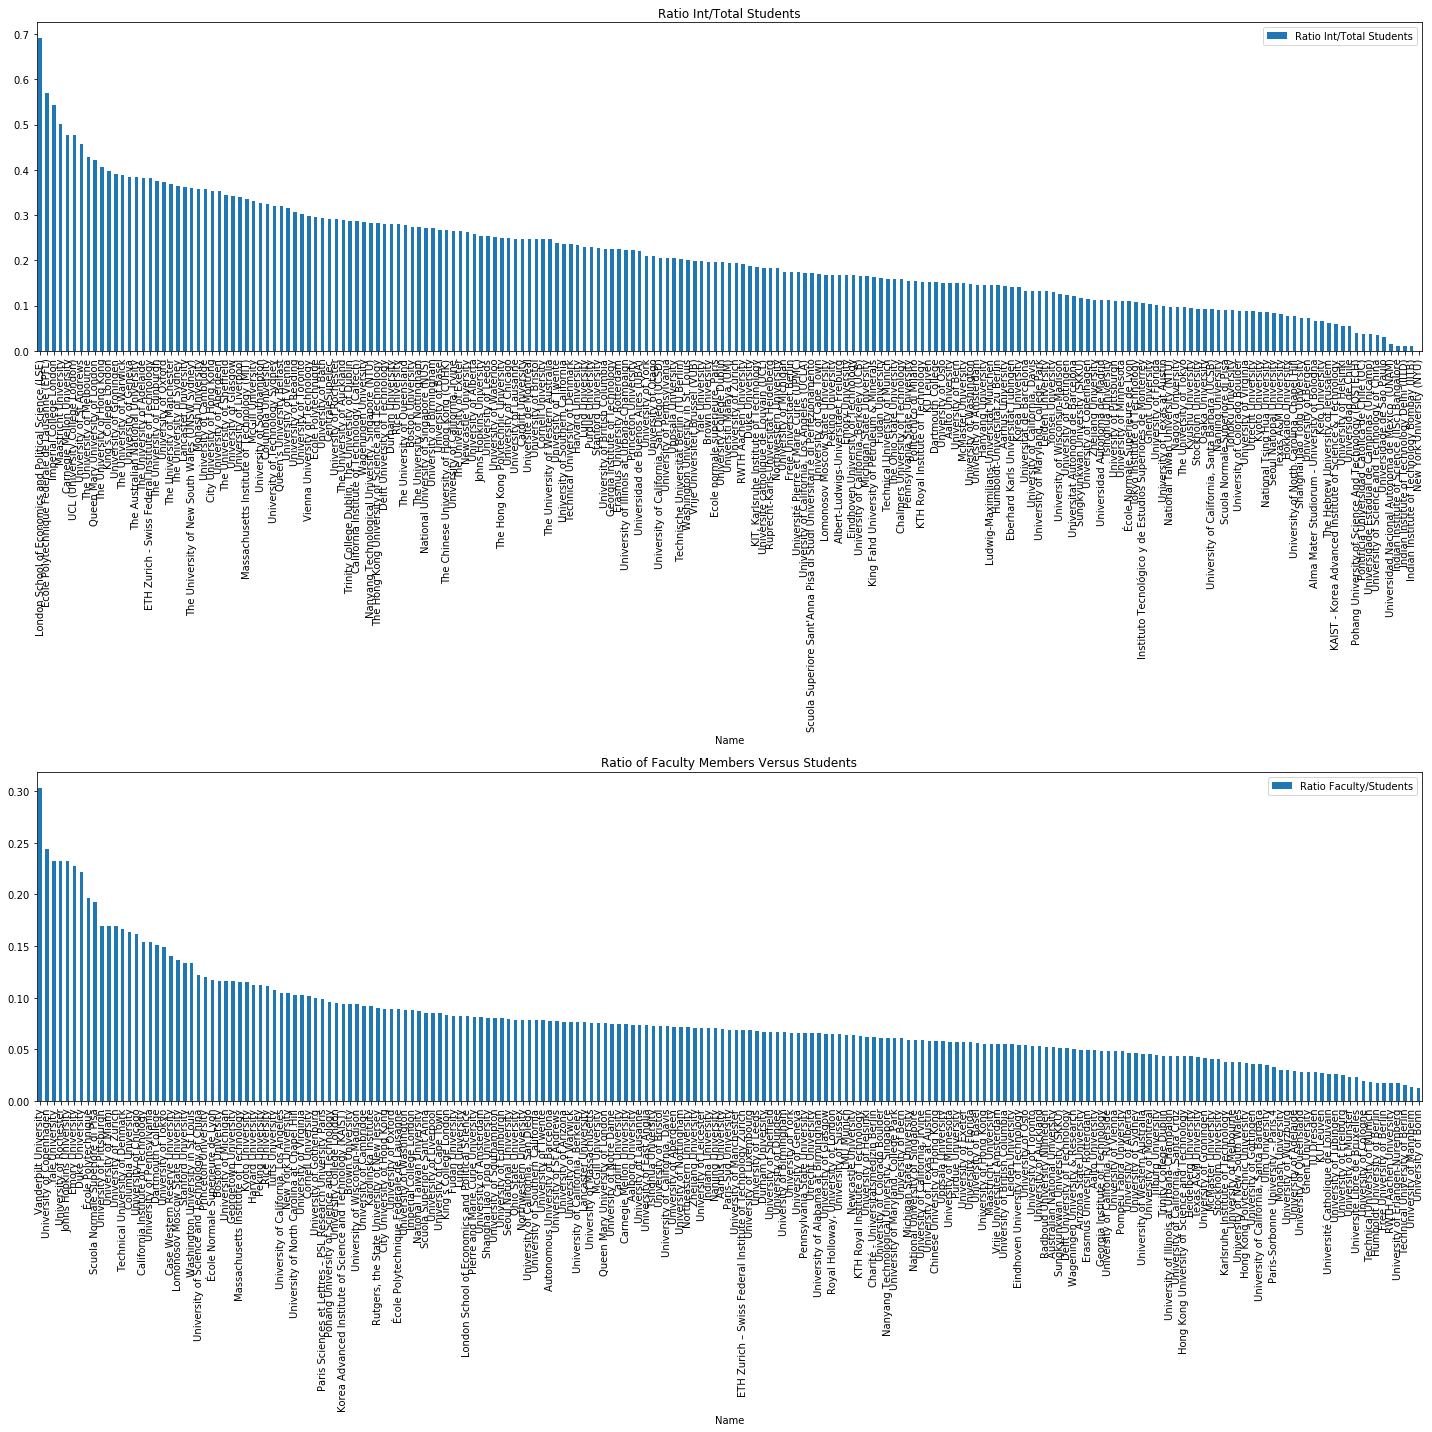

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols =1, figsize  = (20,20))
ratio_int_students.plot(kind = "bar", subplots = True, ax = axes[0])
plt.title("Ratio of International Students")
ratio_fac_students.plot(kind = "bar", subplots = True, ax = axes[1])
plt.title("Ratio of Faculty Members Versus Students")
fig.tight_layout()

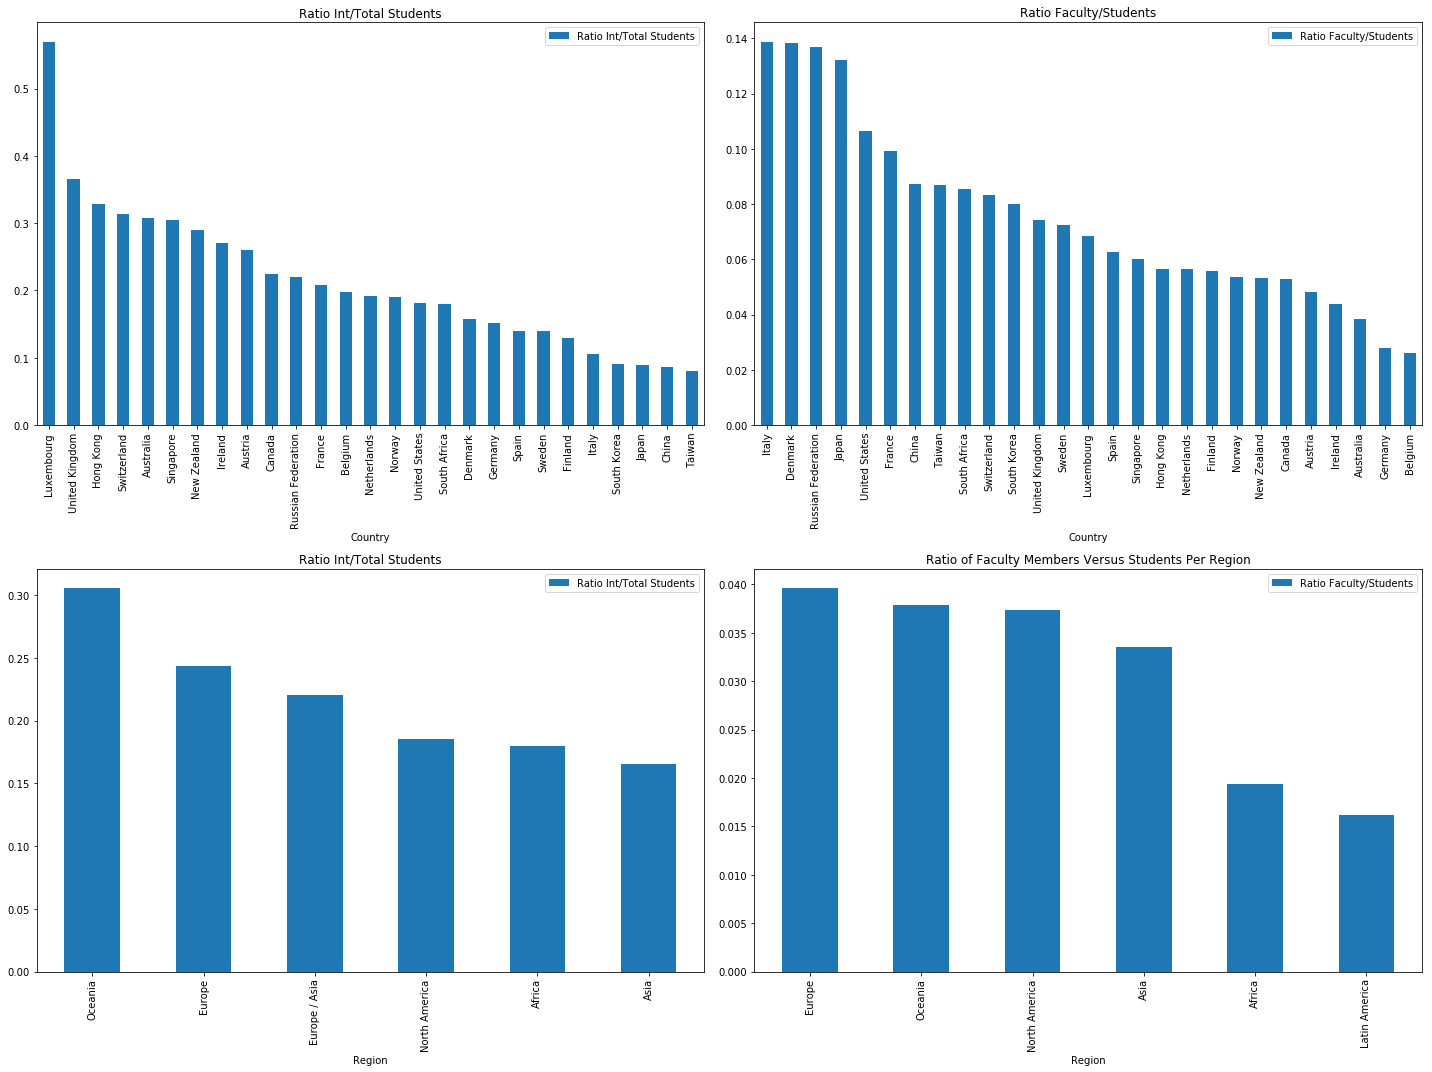

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols =2, figsize  = (20,15))
country_rank_int_total_students.plot(kind = "bar", subplots = True, ax = axes[0,0])
plt.title("Ratio of International Students Per Country")
country_rank_fac_students.plot(kind = "bar", subplots = True, ax = axes[0,1])
plt.title("Ratio of Faculty Members Versus Students Per Country")
region_int_total_students.plot(kind = "bar", subplots = True, ax = axes[1,0])
plt.title("Ratio of International Students Per Region")
region_fac_students.plot(kind = "bar", subplots = True, ax = axes[1,1])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

# TODO : describe briefly what you observed for all the plots

# 3. Merging the DataFrames

The objective here is to merge the dataframes based on the university names. Most of the time the university name is written the same way in both ranking websites. The rest of the time however, the acronyms are added in the string. That is why the idea here was to use the string edition distance or Levenshtein distance to compare the strings one to one. The smallest distance when comparing all the names of the different rankings would therefore correspond to the most likely university 

In [33]:
ranking_THE.Name.tolist()

['University of Oxford',
 'University of Cambridge',
 'California Institute of Technology',
 'Stanford University',
 'Massachusetts Institute of Technology',
 'Harvard University',
 'Princeton University',
 'Imperial College London',
 'University of Chicago',
 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'University of Pennsylvania',
 'Yale University',
 'Johns Hopkins University',
 'Columbia University',
 'University of California, Los Angeles',
 'University College London',
 'Duke University',
 'University of California, Berkeley',
 'Cornell University',
 'Northwestern University',
 'University of Michigan',
 'National University of Singapore',
 'University of Toronto',
 'Carnegie Mellon University',
 'London School of Economics and Political Science',
 'University of Washington',
 'University of Edinburgh',
 'New York University',
 'Peking University',
 'Tsinghua University',
 'University of California, San Diego',
 'University of Melbourne',
 'Georgia Institute of 

In [34]:
ranking_QS.Name.tolist()

['Massachusetts Institute of Technology (MIT)',
 'Stanford University',
 'Harvard University',
 'California Institute of Technology (Caltech)',
 'University of Cambridge',
 'University of Oxford',
 'UCL (University College London)',
 'Imperial College London',
 'University of Chicago',
 'ETH Zurich - Swiss Federal Institute of Technology',
 'Nanyang Technological University, Singapore (NTU)',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)',
 'Princeton University',
 'Cornell University',
 'National University of Singapore (NUS)',
 'Yale University',
 'Johns Hopkins University',
 'Columbia University',
 'University of Pennsylvania',
 'The Australian National University',
 'Duke University',
 'University of Michigan',
 "King's College London",
 'The University of Edinburgh',
 'Tsinghua University',
 'The University of Hong Kong',
 'University of California, Berkeley (UCB)',
 'Northwestern University',
 'The University of Tokyo',
 'The Hong Kong University of Science and Technology',
 

In [35]:
import editdistance

Looking at the university names when the string edition distance was not 0, i.e. if the strings were not exactly the same, we noticed that a few modifications to the strings would help get a better estimate of the string edition distance : 
- Remove or replace odd characters
- Convert everything to lower case
- Remove the word university and all it's translations to avoid the problems of multiple languages

The other thing we noticed was that the acronyms were often either in the begining or the end of the string. Therefore we could check to see if the names of the universities were mutually included. If one of the names is in the other, that is most likely because they are the same. We manually checked that that was the case for all the universities which met the condition. 

In [36]:
def format_string(string):
    # Remove Problematic characters which do not hold relevant information
    string = string.replace("–", "-").replace("-", " ").replace("’","'").replace("é","e")
    string = string.replace(".", "").replace(",", "").replace("&", "and").replace(" and ", " ")
    string = string.replace("(", "").replace(")", "")
    
    # Convert to lower case for uniformity 
    string = string.lower()
    
    # Handling the issues with university and it's translations
    string = re.sub('univers.*? ', '', string) 
    string = re.sub(r'\b\w{1,2}\b', '', string)
    string = re.sub('university', '', string) # Necessary when university is at the start or end of the string
    string = string.replace("  ", " ")
    
    return string

In [37]:
def find_equivalent_of_r1_in_r2(r1,r2):
    found_dict = {}
    not_found_dict = {}
    for name1 in r1.Name.tolist():
        name1_f= format_string(name1)
        distance = []
        for name2 in r2.Name.tolist():
            name2_f= format_string(name2)
            distance.append(editdistance.eval(name2_f, name1_f))
            #print (i, distance[i])  
        min_dist = min(distance)
        idx = distance.index(min_dist)
        #if min(distance)>0:
            #if min(distance) > 6:
        name_found = r2.Name.iloc[idx]
        name_found_f = format_string(name_found)
        condition = (name1_f in name_found_f) or (name_found_f in name1_f)
        if min_dist == 0 or condition:
            found_dict.update({name1: name_found})
        else :
            not_found_dict.update({name1: name_found})
            #print("distance :", min(distance), "\t\t", name1,  " = ",name_found)
    return found_dict,not_found_dict

In [38]:
THE_to_QS, THE_not_in_QS = find_equivalent_of_r1_in_r2(ranking_THE,ranking_QS)
QS_to_THE, QS_not_in_THE = find_equivalent_of_r1_in_r2(ranking_QS,ranking_THE)

The universities which met the suss-mentioned conditions were considered as the same. The others then had to be verified manually as the edition distance is not sufficient to determine whether the names correspond to the same university or not. ex : university of bergen  =  university of bern with a string edition distance of 2 whereas ecole polytechnique federale de lausanne (epfl)  =  école polytechnique federale de lausanne with a string edition distance of 8. 

Looking at the univiersities that are in the THE ranking but not in the QS ranking we find a few univerisities which were not identified as being the same : 
- 'Autonomous University of Barcelona': 'Universitat Autònoma de Barcelona'
- 'École Polytechnique': 'Ecole Polytechnique',
- 'École Polytechnique Fédérale de Lausanne': 'Ecole Polytechnique Fédérale de Lausanne (EPFL)'
- 'Free University of Berlin': 'Freie Universitaet Berlin'

In [39]:
THE_not_in_QS

{'Aalborg University': 'Aalto University',
 'Arizona State University': 'The Ohio State University',
 'Autonomous University of Barcelona': 'Universitat Autònoma de Barcelona',
 'California Institute of Technology': 'Georgia Institute of Technology',
 'Case Western Reserve University': 'The University of Western Australia',
 'Charité - Universitätsmedizin Berlin': 'Freie Universitaet Berlin',
 'Chinese University of Hong Kong': 'The University of Hong Kong',
 'Free University of Berlin': 'Freie Universitaet Berlin',
 'Georgetown University': 'Princeton University',
 'Heidelberg University': 'Leiden University',
 'Indiana University': 'Fudan University',
 'Karolinska Institute': 'Johns Hopkins University',
 'Korea Advanced Institute of Science and Technology (KAIST)': 'KAIST - Korea Advanced Institute of Science & Technology',
 'LMU Munich': 'University of Zurich',
 'Northeastern University': 'Northwestern University',
 'Paris Sciences et Lettres – PSL Research University Paris': 'Ecole

Doing the same for the universities in QS but not in THE we find the same 4 which were not identified: 
- 'Ecole Polytechnique': 'École Polytechnique'
- 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne'
- 'Universitat Autònoma de Barcelona': 'Autonomous University of Barcelona'
- 'Freie Universitaet Berlin': 'Free University of Berlin'

A few new ones were equally noted : 
- 'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advanced Institute of Science and Technology (KAIST)'
- 'Pohang University of Science And Technology (POSTECH)': 'Pohang University of Science and Technology'
- 'Technische Universität Berlin (TU Berlin)': 'Technical University of Berlin'


In [40]:
QS_not_in_THE

{'Alma Mater Studiorum - University of Bologna': 'University of New South Wales',
 'CentraleSupélec': 'Newcastle University',
 'Chalmers University of Technology': 'Delft University of Technology',
 'Ecole Polytechnique': 'École Polytechnique',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne',
 'Ecole normale supérieure, Paris': 'École Normale Supérieure de Lyon',
 'Freie Universitaet Berlin': 'Free University of Berlin',
 'Hanyang University': 'Nanjing University',
 'Hokkaido University': 'Harvard University',
 'Indian Institute of Science (IISc) Bangalore': 'Georgia Institute of Technology',
 'Indian Institute of Technology Bombay (IITB)': 'Georgia Institute of Technology',
 'Indian Institute of Technology Delhi (IITD)': 'Georgia Institute of Technology',
 'Instituto Tecnológico y de Estudios Superiores de Monterrey': 'Nanyang Technological University, Singapore',
 'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advance

Therefore we took the 7 missing universities and added them to a final dictionary which contains the QS names as keys and the THE names as values. 

In [41]:
QS_to_THE.update({'Ecole Polytechnique': 'École Polytechnique'})
QS_to_THE.update({'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne'})
QS_to_THE.update({'Universitat Autònoma de Barcelona': 'Autonomous University of Barcelona'})
QS_to_THE.update({'Freie Universitaet Berlin': 'Free University of Berlin'})
QS_to_THE.update({'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advanced Institute of Science and Technology (KAIST)'})
QS_to_THE.update({'Pohang University of Science And Technology (POSTECH)': 'Pohang University of Science and Technology'})
QS_to_THE.update({'Technische Universität Berlin (TU Berlin)': 'Technical University of Berlin'})

del QS_not_in_THE['Ecole Polytechnique']
del QS_not_in_THE['Ecole Polytechnique Fédérale de Lausanne (EPFL)']
del QS_not_in_THE['Universitat Autònoma de Barcelona']
del QS_not_in_THE['Freie Universitaet Berlin']
del QS_not_in_THE['KAIST - Korea Advanced Institute of Science & Technology']
del QS_not_in_THE['Pohang University of Science And Technology (POSTECH)']
del QS_not_in_THE['Technische Universität Berlin (TU Berlin)']

del THE_not_in_QS['École Polytechnique']
del THE_not_in_QS['École Polytechnique Fédérale de Lausanne']
del THE_not_in_QS['Autonomous University of Barcelona']
del THE_not_in_QS['Free University of Berlin']

In [ ]:
# Set Index for both rankings
ranking_QS = ranking_QS.set_index('Name')
ranking_THE = ranking_THE.set_index('Name')

In [53]:
combined_rankings = pd.DataFrame(columns = ['Name QS','Name THE','Country','Region', 'Rank THE', 'Rank QS'\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])

This function is used to extract specific column information for given university names from the website dataframe. 

In [54]:
def extract_info_for_name(site_name,website_df, names, infos):
    df = pd.DataFrame(columns = infos)
    df[('Name '+site_name)] = names
    for info in infos:
        df[info] = website_df.loc[names,info].tolist()
    return df

In [55]:
# Names in Both Rankings
NameQS = list(QS_to_THE.keys())
NameTHE = list(QS_to_THE.values()) 

# The information we want to extract from each dataframe
infos_QS = ['Country','Region', 'Rank',\
            'Number of faculty members (int)',\
            'Number of faculty members (total)',\
            'Number of students (int)','Number of students (total)']
infos_THE = ['Rank']

# Extracting and merging
df_QS = extract_info_for_name("QS",ranking_QS, NameQS, infos_QS)
df_QS = df_QS.rename(columns={'Rank': 'Rank QS'})
df_THE = extract_info_for_name("THE", ranking_THE, NameTHE,infos_THE)
df_THE = df_THE.rename(columns={'Rank': 'Rank THE'})
result = pd.concat([df_QS, df_THE], axis=1, join_axes=[df_QS.index])
result.head()

,Country,Region,Rank QS,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Name QS,Rank THE,Name THE
0,United States,North America,1,2982.0,1679.0,3717.0,11067.0,Massachusetts Institute of Technology (MIT),5,Massachusetts Institute of Technology
1,United States,North America,2,4285.0,2042.0,3611.0,15878.0,Stanford University,3,Stanford University
2,United States,North America,3,4350.0,1311.0,5266.0,22429.0,Harvard University,6,Harvard University
3,United States,North America,4,953.0,350.0,647.0,2255.0,California Institute of Technology (Caltech),3,California Institute of Technology
4,United Kingdom,Europe,5,5490.0,2278.0,6699.0,18770.0,University of Cambridge,2,University of Cambridge


In [56]:
names = [list(QS_not_in_THE.keys()), list(THE_not_in_QS.keys())]
site_dfs = [ranking_QS, ranking_THE]
site_name = ['QS', 'THE']

# Adding information for universities in one ranking but not in the other
for univ_names, df, site in zip(names, site_dfs, site_name):
    temp_df = df[infos_QS].loc[univ_names]
    temp_df = temp_df.reset_index()
    temp_df = temp_df.rename(columns={'Rank': ('Rank '+ site), \
                                      'Name ' : ('Name '+ site)})
    # Combining the intermediate dataframe with the result
    result = result.append(temp_df, ignore_index=True)
result

,Country,Name,Name QS,Name THE,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region
0,United States,NaN,Massachusetts Institute of Technology (MIT),Massachusetts Institute of Technology,2982.0,1679.0,3717.0,11067.0,1.0,5.0,North America
1,United States,NaN,Stanford University,Stanford University,4285.0,2042.0,3611.0,15878.0,2.0,3.0,North America
2,United States,NaN,Harvard University,Harvard University,4350.0,1311.0,5266.0,22429.0,3.0,6.0,North America
3,United States,NaN,California Institute of Technology (Caltech),California Institute of Technology,953.0,350.0,647.0,2255.0,4.0,3.0,North America
4,United Kingdom,NaN,University of Cambridge,University of Cambridge,5490.0,2278.0,6699.0,18770.0,5.0,2.0,Europe
5,United Kingdom,NaN,University of Oxford,University of Oxford,6750.0,2964.0,7353.0,19720.0,6.0,1.0,Europe
6,United Kingdom,NaN,UCL (University College London),University College London,6345.0,2554.0,14854.0,31080.0,7.0,16.0,Europe
7,United Kingdom,NaN,Imperial College London,Imperial College London,3930.0,2071.0,8746.0,16090.0,8.0,8.0,Europe
8,United States,NaN,University of Chicago,University of Chicago,2449.0,635.0,3379.0,13557.0,9.0,9.0,North America
9,Switzerland,NaN,ETH Zurich - Swiss Federal Institute of Techno...,ETH Zurich – Swiss Federal Institute of Techno...,2477.0,1886.0,7563.0,19815.0,10.0,10.0,Europe
